<a href="https://colab.research.google.com/github/frizchar/Sales-Forecasting/blob/main/Sales_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sales Forecasting using the Facebook Prophet Algorithm

## Import Packages & Read Data

In [1]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
import os
import datetime   

In [2]:
df = pd.read_csv('/content/sample_data/data.csv', keep_default_na=False, parse_dates=['date'], infer_datetime_format=True, header = 0)  
df.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,15.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,8.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,10.0
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,2.0


In [3]:
#get max date of the dataset
print(max(df['date']))

2017-08-15 00:00:00


## Exploratory Data Analysis

In [4]:
#get datatype of each column
df.dtypes 

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion           float64
dtype: object

In [5]:
#check for rows with a null value in at least one column
print(df[df.isnull().any(axis=1)]) 
#get the shape of the dataset
df.shape                            

Empty DataFrame
Columns: [id, date, store_nbr, family, sales, onpromotion]
Index: []


(3000888, 6)

In [6]:
#get unique values of each column   
print(df.apply(lambda col: col.unique())) 

id             [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
date           [2013-01-01T00:00:00.000000000, 2013-01-02T00:...
store_nbr      [1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 2,...
family         [AUTOMOTIVE, BABY CARE, BEAUTY, BEVERAGES, BOO...
sales          [0.0, 2.0, 810.0, 180.58900000000003, 186.0, 1...
onpromotion    [0.0, 5.0, 2.0, 126.0, 55.0, 174.0, 119.0, 41....
dtype: object


In [7]:
df['family'] = df['family'].astype('string')              #change column 'family' datatype from object to string
df.dtypes                                                 #get datatype of columns of new dataframe df2

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 string
sales                 float64
onpromotion           float64
dtype: object

In [8]:
df_fam = df.groupby(['family'])['sales'].sum().to_frame(name = 'Total_Sales_per_Family').reset_index()  #group total orders by product
df2_fam = df_fam.sort_values(by='Total_Sales_per_Family', ascending=False)
df2_fam.head()  #inspect top selling product categories (product families)

,family,Total_Sales_per_Family
12,GROCERY I,3.434627e+08
3,BEVERAGES,2.169545e+08
30,PRODUCE,1.227047e+08
7,CLEANING,9.752129e+07
8,DAIRY,6.448771e+07


In [9]:
df_st = df.groupby(['store_nbr'])['sales'].sum().to_frame(name = 'Total_Sales_per_Store').reset_index()  #group total orders by product
df2_st = df_st.sort_values(by='Total_Sales_per_Store', ascending=False)
df2_st.head()  #inspect top selling stores

,store_nbr,Total_Sales_per_Store
43,44,6.208755e+07
44,45,5.449801e+07
46,47,5.094831e+07
2,3,5.048191e+07
48,49,4.342010e+07


In [10]:
df_fam44 = df[df['store_nbr']==44].groupby(['family'])['sales'].sum().to_frame(name = 'Total_Sales_per_Family').reset_index()  #group total orders by product
df2_fam44 = df_fam44.sort_values(by='Total_Sales_per_Family', ascending=False)
df2_fam44.head()  #inspect top selling product categories (product families) within top selling store_nbr = 44

,family,Total_Sales_per_Family
12,GROCERY I,1.638606e+07
3,BEVERAGES,1.341786e+07
30,PRODUCE,1.066606e+07
7,CLEANING,4.308260e+06
8,DAIRY,4.277954e+06


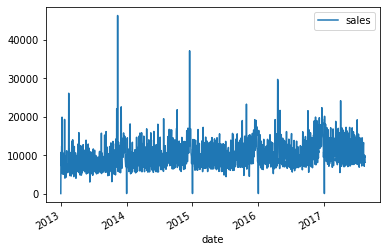

In [11]:
#plot time series of Sales of store_nbr=44 and family='GROCERY I' over time
df[(df['store_nbr']==44) & (df['family']=='GROCERY I')].plot(x='date',y='sales')

In [12]:
#generate dataset of store_nbr=44 and family='GROCERY I'
df_store44_grocery = df[(df['store_nbr']==44) & (df['family']=='GROCERY I')] 

In [13]:
def grouped(df, key, freq, col):
    """ group data of certain frequency by sum """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(sum = (col, 'sum'))
    df_grouped = df_grouped.reset_index()
    return df_grouped   


In [14]:
def add_time(df, key, freq, col):
    """ add column 'time' to df """
    df_grouped = grouped(df, key, freq, col)
    df_grouped['time'] = np.arange(len(df_grouped.index))
    column_time = df_grouped.pop('time')
    df_grouped.insert(1, 'time', column_time)
    return df_grouped

In [15]:
# generate weekly dataset based on dataset df2
df_weekly = add_time(df_store44_grocery, 'date', 'W', 'sales')
df_weekly.tail()

,date,time,sum
237,2017-07-23,237,73791.0
238,2017-07-30,238,71142.0
239,2017-08-06,239,75507.0
240,2017-08-13,240,61038.0
241,2017-08-20,241,16441.0


In [16]:
#drop last value of df_weekly dataset
df_weekly.drop(df_weekly.tail(1).index,inplace=True)

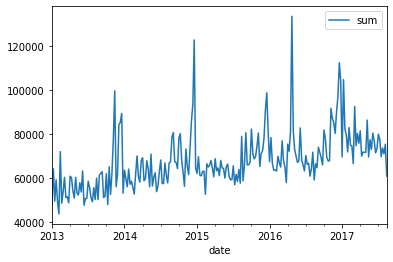

In [17]:
#plot time series of Sales of product line 'Health and beauty' over time
df_weekly.plot(x='date',y='sum') 

## Model Building

In [18]:
#drop column 'time'
df_prophet = df_weekly.drop(['time'], axis=1) 
#rename columns to y and ds so that Prophet works
df_prophet.rename(columns={"date": "ds", "sum": "y"}, inplace=True) 
df_prophet.tail()

,ds,y
236,2017-07-16,69860.0
237,2017-07-23,73791.0
238,2017-07-30,71142.0
239,2017-08-06,75507.0
240,2017-08-13,61038.0


In [19]:
#consider holiday dates
holidays = pd.DataFrame({
  'holiday': 'christmas',
  'ds': pd.to_datetime(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25', '2017-12-25']),
  'lower_window': 0,
  'upper_window': 1,
})

In [20]:
df_prophet.head()

,ds,y
0,2013-01-06,48350.0
1,2013-01-13,64362.0
2,2013-01-20,49703.0
3,2013-01-27,59342.0
4,2013-02-03,49611.0


In [21]:
m = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=True, holidays=holidays)#, seasonality_mode='multiplicative')
model = m.fit(df_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


## Forecasting

In [22]:
future = m.make_future_dataframe(periods=12, freq='W')
future['floor'] = 0
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,christmas,christmas_lower,christmas_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-06,50357.826728,41263.705754,74491.969220,50357.826728,50357.826728,6205.684460,6205.684460,6205.684460,0.0,0.0,0.0,0.0,0.0,0.0,6115.741751,6115.741751,6115.741751,89.942708,89.942708,89.942708,0.0,0.0,0.0,56563.511188
1,2013-01-13,50456.953703,37420.976141,67604.604592,50456.953703,50456.953703,2521.748461,2521.748461,2521.748461,0.0,0.0,0.0,0.0,0.0,0.0,6115.741751,6115.741751,6115.741751,-3593.993291,-3593.993291,-3593.993291,0.0,0.0,0.0,52978.702164
2,2013-01-20,50556.080677,39104.240182,70288.070395,50556.080677,50556.080677,4208.277466,4208.277466,4208.277466,0.0,0.0,0.0,0.0,0.0,0.0,6115.741751,6115.741751,6115.741751,-1907.464285,-1907.464285,-1907.464285,0.0,0.0,0.0,54764.358144
3,2013-01-27,50655.207652,40142.216877,72237.152041,50655.207652,50655.207652,5438.502694,5438.502694,5438.502694,0.0,0.0,0.0,0.0,0.0,0.0,6115.741751,6115.741751,6115.741751,-677.239058,-677.239058,-677.239058,0.0,0.0,0.0,56093.710346
4,2013-02-03,50754.334626,38913.865142,69555.226653,50754.334626,50754.334626,3045.753676,3045.753676,3045.753676,0.0,0.0,0.0,0.0,0.0,0.0,6115.741751,6115.741751,6115.741751,-3069.988075,-3069.988075,-3069.988075,0.0,0.0,0.0,53800.088303


In [23]:
forecast[['ds','yhat']]

,ds,yhat
0,2013-01-06,56563.511188
1,2013-01-13,52978.702164
2,2013-01-20,54764.358144
3,2013-01-27,56093.710346
4,2013-02-03,53800.088303
...,...,...
248,2017-10-08,82197.859346
249,2017-10-15,79288.213591
250,2017-10-22,78516.165342
251,2017-10-29,81889.897785


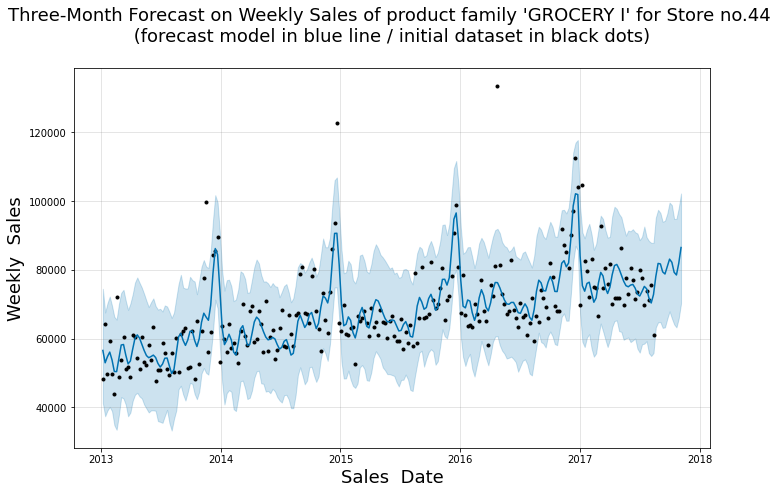

In [24]:
import matplotlib.pyplot as plt

#plot1 = m.plot(forecast)
fig = m.plot(forecast)#, xlabel='Date', ylabel='Weekly Orders')
plt.rcParams["figure.figsize"] = [9.50, 7.50]
#plt.rcParams["figure.autolayout"] = True
ax = fig.gca()
ax.set_title("Three-Month Forecast on Weekly Sales of product family 'GROCERY I' for Store no.44 \n (forecast model in blue line / initial dataset in black dots) \n", size=18)
#ax.set_xlabel("X")
#ax.set_ylabel("Y")
plt.xlabel('Sales  Date', fontsize=18)
plt.ylabel('Weekly  Sales', fontsize=18)
ax.tick_params(axis="x")
ax.tick_params(axis="y")

In [25]:
df_prophet[['ds','y']]

,ds,y
0,2013-01-06,48350.0
1,2013-01-13,64362.0
2,2013-01-20,49703.0
3,2013-01-27,59342.0
4,2013-02-03,49611.0
...,...,...
236,2017-07-16,69860.0
237,2017-07-23,73791.0
238,2017-07-30,71142.0
239,2017-08-06,75507.0


## Results Evaluation

In [26]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='370 days', period='370 days', horizon = '90 days')

INFO:fbprophet:Making 4 forecasts with cutoffs between 2014-05-01 00:00:00 and 2017-05-15 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

In [27]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-04,61336.881283,47475.268701,74871.596055,64325.0,2014-05-01
1,2014-05-11,62463.347864,48756.575293,77152.662045,56224.0,2014-05-01
2,2014-05-18,62880.355554,49416.874985,75849.593045,70982.0,2014-05-01
3,2014-05-25,62284.950730,49259.853197,76273.371266,56535.0,2014-05-01
4,2014-06-01,61768.663197,48045.559176,75518.860160,60546.0,2014-05-01


In [28]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
43,83 days,2.737248e+07,5231.871543,4533.374661,0.072436,0.063188,1.0
44,87 days,3.637785e+07,6031.405322,5698.256981,0.089987,0.083237,1.0
45,88 days,3.178683e+07,5637.981136,4751.061978,0.073513,0.063188,1.0
46,89 days,2.000427e+07,4472.612883,3879.762361,0.055744,0.063188,1.0
47,90 days,4.800925e+07,6928.870614,5689.738695,0.085964,0.063737,1.0


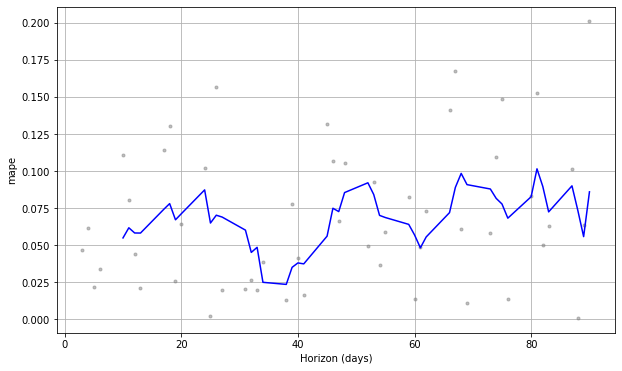

In [29]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')